## Agent Churn Prediction
## Data used for analysis is based on Integral P&C Admin System

### The SQL query in below cells will retreive data based on database credentials provide. Right now these credentials have been left empty for security reasons. Please enter relevant details before running this notebook further.

In [1]:
# Import Packages
import numpy as np
import pandas as pd
import pyodbc

# Get Current time
import datetime 

# For Graphics
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# For splitting data into test and train subsets
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

# For logistic regression
from sklearn.linear_model import LogisticRegression

# For saving the model
from sklearn.externals import joblib 

# For Confusion Matrix
from sklearn import metrics

# For ROC Curve
from sklearn.metrics import roc_auc_score, roc_curve

# For Normalization
from sklearn.preprocessing import MinMaxScaler

# For Feature Selection
from sklearn.feature_selection import SelectKBest, chi2

# Settings to view all columns and rows
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

C:\Users\sisense_admin\.conda\envs\pnc_agent_churn\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Import Data

In [2]:
# Enter ip address and port number of the system where the database resides.
server = '172.31.20.94'
database = 'INT77DB2014_PNC' 
username = 'sisensedb_user'
password = 'Sisense12#$' 

In [3]:
# Add appropriate driver name
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

In [4]:
# Run Query
query = '''
select 
q1.agntnum				as 'Agent_Number',
q1.srdate				as 'Date_of_Appointment',
case
when
q1.dateend = '99999999'
then 
''
else
cast(q1.dateend as varchar)
end						as 'Date_of_Termination',
q1.agtype				as 'Agent_Type',
q1.agntbr				as 'Agent_Branch_Code',
q1.replvl				as 'Agent_Reporting_Level',
q1.stca					as 'Territory',
q1.stcb					as 'Source',
q1.stcc					as 'Major_Class',
q1.stcd					as 'Statistical_Code',
q1.stce					as 'Distribution_Channel',
q1.prodctcatg			as 'Product_Category',
isnull(q1.crlimit,0)	as 'Credit_Limit',
q1.stlbasis				as 'Settlement_Basis',
q1.arcon				as 'Reconciliation',

case
when 
q2.cltdob = '99999999'
then 
''
else
cast (q2.cltdob as varchar)
end									as 'Agent_Date_of_Birth',
q2.cltsex							as 'Agent_Gender',
isnull(q3.policies,0)				as 'Number_of_Policies',
isnull(q4.claims,0)					as 'Number_of_Claims',
isnull(abs(q5.claim_payment),0)		as 'Total_Claim_Paid_Amount',
isnull(q6.commission,0)				as 'Total_Commission_Amount',
case
when
q1.dateend = 99999999
then 
0
else
1
end
						as 'Churn'

from 
(select agntcoy, agntnum, clntnum, agtype, agntbr, replvl, srdate, dateend, stca, stcb, stcc, stcd, stce, prodctcatg, crlimit, stlbasis, arcon
from vm1dta.agntpf where agntcoy='1' and agntnum not in ('1','.')) q1
inner join 
(select * from vm1dta.clntpf where validflag='1') q2
on q2.clntnum = q1.clntnum
left outer join
(select agntnum, count(distinct chdrnum) as policies from vm1dta.chdrpf where chdrcoy = '1' group by agntnum )q3
on q3.agntnum = q1.agntnum
left outer join 
(select agntnum, count(distinct claim) as claims from vm1dta.clampf where clmcoy = '1' group by agntnum)q4
on q4.agntnum = q1.agntnum
left outer join 
(select agntnum, sum(paid) as claim_payment from vm1dta.clampf where clmcoy = '1' group by agntnum)q5
on q5.agntnum = q1.agntnum
left outer join 
(select acnum, sum(tranamt04) as commission from vm1dta.ztrnpf where batccoy = '1' group by acnum)q6
on q6.acnum = q1.agntnum

order by q1.agntnum
'''

In [5]:
# Read data
df_orig = pd.read_sql(query,cnxn)

# Close the cursor
cursor.close() 

In [6]:
# Check data sample
df_orig.head()

Agent_Number  Date_of_Appointment Date_of_Termination Agent_Type  \
0     0001565              20150101                             20   
1     0001646              20150201                             01   
2     0001717              20120101                             01   
3     0002197              20150601                             01   
4     0002332              20150601                             01   

  Agent_Branch_Code  Agent_Reporting_Level Territory Source Major_Class  \
0                10                      1       L      FOW               
1                10                      1       L      AGY               
2                10                      1       L      AGY               
3                10                      1       L      AGY               
4                10                      1       L      AGY               

  Statistical_Code Distribution_Channel Product_Category  Credit_Limit  \
0                                                   None             0   
1                                                   None             0   
2                                                   None             0   
3                                                   None             0   
4                                                   None             0   

  Settlement_Basis Reconciliation Agent_Date_of_Birth Agent_Gender  \
0                                            20150101                
1                                                                    
2                                                                    
3                                            20150601            M   
4                                            19801011            M   

   Number_of_Policies  Number_of_Claims  Total_Claim_Paid_Amount  \
0                   1                 0                      0.0   
1                   3                 1                      0.0   
2                   0                 0                      0.0   
3                   1                 0                      0.0   
4                   1                 1                      0.0   

   Total_Commission_Amount  Churn  
0                      0.0      0  
1                      0.0      0  
2                      0.0      0  
3                      0.0      0  
4                      0.0      0

## Data Analysis & Visualization

In [7]:
# Check data shape
df_orig.shape

(10407, 22)

In [8]:
# Check data attributes of the columns
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Agent_Number             10407 non-null  object 
 1   Date_of_Appointment      10407 non-null  int64  
 2   Date_of_Termination      10407 non-null  object 
 3   Agent_Type               10407 non-null  object 
 4   Agent_Branch_Code        10407 non-null  object 
 5   Agent_Reporting_Level    10407 non-null  int64  
 6   Territory                10407 non-null  object 
 7   Source                   10407 non-null  object 
 8   Major_Class              10407 non-null  object 
 9   Statistical_Code         10407 non-null  object 
 10  Distribution_Channel     10407 non-null  object 
 11  Product_Category         9857 non-null   object 
 12  Credit_Limit             10407 non-null  int64  
 13  Settlement_Basis         10407 non-null  object 
 14  Reconciliation        

In [9]:
# View distribution of 'Churn' Instances
df_orig['Churn'].value_counts()

0    10398
1        9
Name: Churn, dtype: int64

In [10]:
# Check if there are any nulls
df_orig.isnull().sum()

Agent_Number                 0
Date_of_Appointment          0
Date_of_Termination          0
Agent_Type                   0
Agent_Branch_Code            0
Agent_Reporting_Level        0
Territory                    0
Source                       0
Major_Class                  0
Statistical_Code             0
Distribution_Channel         0
Product_Category           550
Credit_Limit                 0
Settlement_Basis             0
Reconciliation               0
Agent_Date_of_Birth          0
Agent_Gender                 0
Number_of_Policies           0
Number_of_Claims             0
Total_Claim_Paid_Amount      0
Total_Commission_Amount      0
Churn                        0
dtype: int64

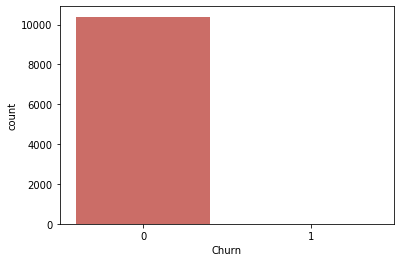

In [11]:
# Plot count values
df_orig.Churn.value_counts()
sns.countplot(x = 'Churn', data = df_orig, palette = 'hls')
plt.show()

## Data Treatment

In [12]:
# Create a copy of dataframe
df_work = df_orig.copy()

In [13]:
# Separate features into categorical, numerical and category
cat_vars = ['Agent_Type', 'Agent_Branch_Code','Agent_Reporting_Level','Territory','Source','Major_Class',
            'Statistical_Code','Distribution_Channel','Product_Category','Settlement_Basis','Reconciliation',
            'Agent_Gender']

num_vars = ['Credit_Limit','Number_of_Policies', 'Number_of_Claims', 'Total_Claim_Paid_Amount','Total_Commission_Amount']

date_vars = ['Date_of_Appointment', 'Date_of_Termination', 'Agent_Date_of_Birth' ]

In [14]:
# Convert date columns
date_vars = ['Date_of_Appointment','Date_of_Termination','Agent_Date_of_Birth' ]
for var in date_vars:
    df_work[var]=pd.to_datetime(df_work[var].astype(str), format='%Y-%m-%d')

In [15]:
# Convert to 'category' object type
for var in cat_vars:
    df_work[var] = df_work[var].astype('category')

In [16]:
# Create Dummy Variables for categorical variables
for var in cat_vars:
    cat_list = 'var'+'_'+var
    cat_list = pd.get_dummies(df_work[var], prefix=var)
    dummy_data = df_work.join(cat_list)
    df_work = dummy_data

In [17]:
# Check data shape after dummy encoding
df_work.shape

(10407, 102)

In [18]:
# Remove original columns for which dummy variables have been created
vars_remove = ['Agent_Type', 'Agent_Branch_Code','Agent_Reporting_Level','Territory','Source','Major_Class',
            'Statistical_Code','Distribution_Channel','Product_Category','Settlement_Basis','Reconciliation',
            'Agent_Gender']

for var in vars_remove:
    df_work=df_work.drop(var, axis=1)

In [19]:
# Normalize numerical columns
scaler = MinMaxScaler()
df_work['Credit_Limit'] = scaler.fit_transform(df_work['Credit_Limit'].values.reshape(-1,1))
df_work['Number_of_Policies'] = scaler.fit_transform(df_work['Number_of_Policies'].values.reshape(-1,1))
df_work['Number_of_Claims'] = scaler.fit_transform(df_work['Number_of_Claims'].values.reshape(-1,1))
df_work['Total_Claim_Paid_Amount'] = scaler.fit_transform(df_work['Total_Claim_Paid_Amount'].values.reshape(-1,1))
df_work['Total_Commission_Amount'] = scaler.fit_transform(df_work['Total_Commission_Amount'].values.reshape(-1,1))

### Feature Engineering

In [20]:
# Get current date
current_time = datetime.datetime.now() 

In [21]:
# Create a new column 'Age' on the basis of date of birth of agent
df_work['age'] = current_time - df_work['Agent_Date_of_Birth']

In [22]:
# Create a new column named 'service period' on the basis of difference between Agent Date of Registration and Termination.
# In case date of Termination is null we will replace it with current date and compute

service_period=[]

for Date_of_Termination,Date_of_Appointment in zip(df_work.iloc[:,2], df_work.iloc[:,1]):
    if Date_of_Termination is pd.NaT:
        service_period.append(abs(current_time-Date_of_Appointment))
    else:
        service_period.append(abs(Date_of_Termination-Date_of_Appointment))


In [23]:
# Append the new column to dataframe
df_work['Service_Period']=service_period

# Remove the orginal columns
df_work=df_work.drop('Date_of_Appointment', axis=1)
df_work=df_work.drop('Date_of_Termination', axis=1)
df_work=df_work.drop('Agent_Date_of_Birth', axis=1)

# Remove Agent Number since it is not critical for prediction
df_work=df_work.drop('Agent_Number', axis=1)

In [24]:
# Check contents once
df_work.head()

Credit_Limit  Number_of_Policies  Number_of_Claims  \
0           0.0            0.000601          0.000000   
1           0.0            0.001802          0.004237   
2           0.0            0.000000          0.000000   
3           0.0            0.000601          0.000000   
4           0.0            0.000601          0.004237   

   Total_Claim_Paid_Amount  Total_Commission_Amount  Churn  Agent_Type_**  \
0                      0.0                 0.002606      0              0   
1                      0.0                 0.002606      0              0   
2                      0.0                 0.002606      0              0   
3                      0.0                 0.002606      0              0   
4                      0.0                 0.002606      0              0   

   Agent_Type_01  Agent_Type_02  Agent_Type_03  Agent_Type_04  Agent_Type_05  \
0              0              0              0              0              0   
1              1              0              0              0              0   
2              1              0              0              0              0   
3              1              0              0              0              0   
4              1              0              0              0              0   

   Agent_Type_06  Agent_Type_07  Agent_Type_08  Agent_Type_09  Agent_Type_10  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   Agent_Type_11  Agent_Type_12  Agent_Type_15  Agent_Type_17  Agent_Type_20  \
0              0              0              0              0              1   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   Agent_Type_21  Agent_Type_23  Agent_Type_25  Agent_Type_30  Agent_Type_32  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   Agent_Type_37  Agent_Type_41  Agent_Type_42  Agent_Type_60  Agent_Type_63  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   Agent_Type_64  Agent_Type_65  Agent_Type_71  Agent_Type_82  Agent_Type_83  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   Agent_Branch_Code_**  Agent_Branch_Code_10  Agent_Branch_Code_SG  \
0                     0                     1                     0   
1                     0                     1                     0   
2                     0                     1                     0   
3                     0    

In [25]:
# Normalize the new columns 
scaler = MinMaxScaler()
df_work['age'] = scaler.fit_transform(df_work['age'].values.reshape(-1,1))
df_work['Service_Period'] = scaler.fit_transform(df_work['Service_Period'].values.reshape(-1,1))

In [26]:
# Create separate dataset for feature and target columns
X = df_work.drop('Churn', axis=1)
y = df_work['Churn']

### Performing SMOTE operation to handle class imbalance

In [27]:
# Perform Test/Train Split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3,random_state=11)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7284, 87), (3123, 87), (7284,), (3123,))

In [28]:
# To handle class imbalance performing SMOTE

from imblearn.over_sampling import SMOTE
SMO = SMOTE(random_state=11)

X_train_smo, y_train_smo = SMO.fit_sample(X_train, y_train)
columns = X_train.columns

X_train_smo = pd.DataFrame(data = X_train_smo, columns = columns )
y_train_smo = pd.DataFrame(data = y_train_smo, columns = ['Churn'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(X_train_smo))
print("Number of Non Churned agents in oversampled data",len(y_train_smo[y_train_smo['Churn']== 0 ]))
print("Number of Churned agents in oversampled data",len(y_train_smo[y_train_smo['Churn']== 1 ]))
print("Proportion of Non Churned agents in oversampled data is ",len(y_train_smo[y_train_smo['Churn']== 0])/len(X_train_smo))
print("Proportion of Churned Agents in oversampled data is ",len(y_train_smo[y_train_smo['Churn']== 1 ])/len(X_train_smo))

length of oversampled data is  14556
Number of Non Churned agents in oversampled data 7278
Number of Churned agents in oversampled data 7278
Proportion of Non Churned agents in oversampled data is  0.5
Proportion of Churned Agents in oversampled data is  0.5


# Model Application

### TPOT Model

In [29]:
#Import tpot classifier from tpot and initialize it to run for max generation = 5 OR max time = 60 mins
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=5, verbosity=2, max_time_mins=60, n_jobs = -1)
tpot.fit(X_train_smo, y_train_smo)

C:\Users\sisense_admin\.conda\envs\pnc_agent_churn\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



5.77 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=0.1, min_samples_leaf=2, min_samples_split=4, n_estimators=100)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=False, early_stop=None, generations=5,
               max_eval_time_mins=5, max_time_mins=5, memory=None,
               mutation_rate=0.9, n_jobs=-1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=100,
               random_state=None, scoring=None, subsample=1.0, template=None,
               use_dask=False, verbosity=2, warm_start=False)

In [30]:
# Fit the pipeline
TPOT_Fit_pipeline=tpot.fitted_pipeline_
TPOT_Fit_pipeline

Pipeline(memory=None,
         steps=[('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features=0.1,
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=2, min_samples_split=4,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [31]:
# Print score
print(tpot.score(X_test, y_test))

0.9993595901376882


In [32]:
# Make Predictions
y_pred=TPOT_Fit_pipeline.predict(X_test)

In [33]:
# Make Confusion Matrix to compare results against actuals
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix  

array([[3120,    0],
       [   2,    1]], dtype=int64)

In [34]:
# Get Accuracy Scores
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9993595901376882
Precision: 1.0
Recall: 0.3333333333333333


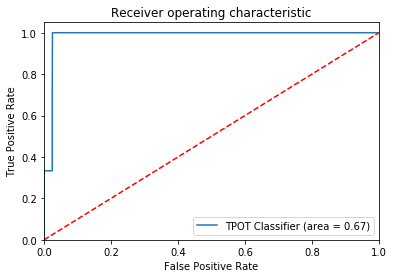

In [35]:
# Print ROC AUC Curve

logit_roc_auc = roc_auc_score(y_test, TPOT_Fit_pipeline.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, TPOT_Fit_pipeline.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='TPOT Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Run the model on entire dataset and save the output in a csv file

In [36]:
# Copy the original data set
df_test = df_orig.copy()

In [37]:
# Separate features into categorical, numerical and category
cat_vars = ['Agent_Type', 'Agent_Branch_Code','Agent_Reporting_Level','Territory','Source','Major_Class',
            'Statistical_Code','Distribution_Channel','Product_Category','Settlement_Basis','Reconciliation',
            'Agent_Gender']

num_vars = ['Credit_Limit','Number_of_Policies', 'Number_of_Claims', 'Total_Claim_Paid_Amount','Total_Commission_Amount']

date_vars = ['Date_of_Appointment', 'Date_of_Termination', 'Agent_Date_of_Birth' ]

In [38]:
# Convert date columns
date_vars = ['Date_of_Appointment','Date_of_Termination','Agent_Date_of_Birth' ]
for var in date_vars:
    df_test[var]=pd.to_datetime(df_test[var].astype(str), format='%Y-%m-%d')

In [39]:
# Convert to 'category' object type
for var in cat_vars:
    df_test[var] = df_test[var].astype('category')

In [40]:
# Create Dummy Variables for categorical variables
for var in cat_vars:
    cat_list = 'var'+'_'+var
    cat_list = pd.get_dummies(df_test[var], prefix=var)
    dummy_data = df_test.join(cat_list)
    df_test = dummy_data

In [41]:
# Check data shape after dummy encoding
df_test.shape

(10407, 102)

In [42]:
# Remove original columns for which dummy variables have been created and also the taget value 'Churn'
vars_remove = ['Agent_Type', 'Agent_Branch_Code','Agent_Reporting_Level','Territory','Source','Major_Class',
            'Statistical_Code','Distribution_Channel','Product_Category','Settlement_Basis','Reconciliation',
            'Agent_Gender','Churn']

for var in vars_remove:
    df_test=df_test.drop(var, axis=1)

### Feature Engineering

In [43]:
# Get current date
current_time = datetime.datetime.now() 

In [44]:
# Create a new column 'Age' on the basis of date of birth of agent
df_test['age'] = current_time - df_test['Agent_Date_of_Birth']

In [45]:
# Create a new column named 'service period' on the basis of difference between Agent Date of Registration and Termination.
# In case date of Termination is null we will replace it with current date and compute

service_period=[]

for Date_of_Termination,Date_of_Appointment in zip(df_test.iloc[:,2], df_test.iloc[:,1]):
    if Date_of_Termination is pd.NaT:
        service_period.append(abs(current_time-Date_of_Appointment))
    else:
        service_period.append(abs(Date_of_Termination-Date_of_Appointment))


In [46]:
# Append the new column to dataframe
df_test['Service_Period']=service_period

# Remove the orginal columns
df_test=df_test.drop('Date_of_Appointment', axis=1)
df_test=df_test.drop('Date_of_Termination', axis=1)
df_test=df_test.drop('Agent_Date_of_Birth', axis=1)

# Remove Agent Number since it is not critical for prediction
df_test=df_test.drop('Agent_Number', axis=1)

In [47]:
# Normalize the new columns 
scaler = MinMaxScaler()
df_test['age'] = scaler.fit_transform(df_test['age'].values.reshape(-1,1))
df_test['Service_Period'] = scaler.fit_transform(df_test['Service_Period'].values.reshape(-1,1))

In [50]:
# Make predictions
prediction_class = TPOT_Fit_pipeline.predict(df_test)
prediction_prob = TPOT_Fit_pipeline.predict_proba(df_test)

# Get Individual Probabilities
not_churn, churn = (prediction_prob).T

In [51]:
# Save original dataframe in a separate dataframe
df_results = df_orig.copy()

In [52]:
# Remove target column
df_results=df_results.drop('Churn',axis=1)

In [53]:
# Replace target column with predicted value of '0' or '1' along with respective probablities
df_results['notchurn'] = not_churn
df_results['churn'] = churn
df_results['churn_prediction_class'] = prediction_class

### Though care has been taken in testing the query output, still double check for duplicate rows for an agent in the csv file

In [54]:
df_results.to_csv('EX_SOURCE_AGENT_CHURN_PNC.csv', index = None, header=True) 

### Save Model as PMML file

In [55]:
joblib.dump(TPOT_Fit_pipeline, 'pnc_agent_churn.pmml') 

['pnc_agent_churn.pmml']